In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import seaborn as sns

In [5]:
df_completados = pd.read_parquet('../data/silver/transacciones_concretadas.parquet')
df_abandonados = pd.read_parquet('../data/silver/transacciones_canceladas.parquet')

In [6]:
print(df_abandonados.columns)

Index(['TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Price',
       'Quantity', 'CustomerNo', 'Country'],
      dtype='object')


In [7]:
df_abandonados.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,C581484,12/9/2019,23843,Paper Craft Little Birdie,6.19,-80995,16446,United Kingdom
1,C581490,12/9/2019,22178,Victorian Glass Hanging T-Light,6.19,-12,14397,United Kingdom
2,C581490,12/9/2019,23144,Zinc T-Light Holder Stars Small,6.04,-11,14397,United Kingdom
3,C581568,12/9/2019,21258,Victorian Sewing Box Large,6.19,-5,15311,United Kingdom
4,C581569,12/9/2019,84978,Hanging Heart Jar T-Light Holder,6.19,-1,17315,United Kingdom


In [8]:
df_completados.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069,United Kingdom


In [9]:
df_abandonados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionNo  8494 non-null   object 
 1   Date           8494 non-null   object 
 2   ProductNo      8494 non-null   object 
 3   ProductName    8494 non-null   object 
 4   Price          8494 non-null   float64
 5   Quantity       8494 non-null   int64  
 6   CustomerNo     8494 non-null   int32  
 7   Country        8494 non-null   object 
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 497.8+ KB


In [10]:
df_abandonados.value_counts()

TransactionNo  Date       ProductNo  ProductName                       Price  Quantity  CustomerNo  Country       
C581569        12/9/2019  84978      Hanging Heart Jar T-Light Holder  6.19   -1        17315       United Kingdom    1
C536383        12/1/2018  35004C     Set Of 3 Coloured Flying Ducks    15.02  -1        15311       United Kingdom    1
C536391        12/1/2018  21484      Chick Grey Hot Water Bottle       13.79  -12       17548       United Kingdom    1
                          21980      Pack Of 12 Red Retrospot Tissues  10.55  -24       17548       United Kingdom    1
                          21983      Pack Of 12 Blue Paisley Tissues   10.55  -24       17548       United Kingdom    1
                                                                                                                     ..
C536548        12/1/2018  22245      Hook 1 Hanger Magic Garden        11.12  -2        12472       Germany           1
                          22244      3 Hook H

In [11]:
df_completados.value_counts()

TransactionNo  Date       ProductNo  ProductName                        Price  Quantity  CustomerNo  Country       
581587         12/9/2019  23256      Childrens Cutlery Spaceboy         6.19   4         12680       France            1
536365         12/1/2018  21730      Glass Star Frosted T-Light Holder  14.61  6         17850       United Kingdom    1
                          22752      Set 7 Babushka Nesting Boxes       18.09  2         17850       United Kingdom    1
                          71053      White Moroccan Metal Lantern       13.72  6         17850       United Kingdom    1
                          84029E     Red Woolly Hottie White Heart      13.72  6         17850       United Kingdom    1
                                                                                                                      ..
536367         12/1/2018  22622      Box Of Vintage Alphabet Blocks     20.45  2         13047       United Kingdom    1
                          22310      

In [12]:
df_completados['Abandonado'] = 0
df_abandonados['Abandonado'] = 1

df_abandonados['Quantity'] = df_abandonados['Quantity'].abs()

df_combined = pd.concat([df_completados, df_abandonados], ignore_index=True)


In [15]:
df_features = df_combined.groupby('TransactionNo').agg(
    total_quantity=('Quantity', 'sum'),
    unique_products=('ProductNo', 'nunique'),
    total_price=('Price', 'sum'),
    average_price=('Price', 'mean'),
    abandon_status=('Abandonado', 'max')  # 1 si hay algún abandono, 0 si solo completado
).reset_index()

df_features.rename(columns={'abandon_status': 'Abandonado'}, inplace=True)

In [21]:
df_features['Abandonado'].value_counts()

Abandonado
0    19789
1     3379
Name: count, dtype: int64

In [22]:
print(df_features)

      TransactionNo  total_quantity  unique_products  total_price  \
0            536365              40                7        99.79   
1            536366              12                2        24.30   
2            536367              83               12       182.69   
3            536368              15                4        60.57   
4            536369               3                1        16.35   
...             ...             ...              ...          ...   
23163       C581470               4                1         6.19   
23164       C581484           80995                1         6.19   
23165       C581490              23                2        12.23   
23166       C581568               5                1         6.19   
23167       C581569               6                2        12.38   

       average_price  Abandonado  
0          14.255714           0  
1          12.150000           0  
2          15.224167           0  
3          15.142500           

In [23]:
print(df_features.dtypes)

TransactionNo       object
total_quantity       int64
unique_products      int64
total_price        float64
average_price      float64
Abandonado           int64
dtype: object


In [30]:
df_numeric_features = df_combined.groupby('TransactionNo').agg(
    total_quantity=('Quantity', 'sum'),
    unique_products=('ProductNo', 'nunique'),
    total_price=('Price', 'sum'),
    average_price=('Price', 'mean'),
    abandon_status=('Abandonado', 'max')
).reset_index()

product_dummies = pd.get_dummies(df_combined[['ProductNo', 'ProductName']], 
                                  prefix=['ProductNo', 'ProductName'], 
                                  drop_first=True)

country_dummies = pd.get_dummies(df_combined[['Country']], 
                                  prefix='Country', 
                                  drop_first=True)

df_numeric_features = df_numeric_features.set_index('TransactionNo')  # Establecer TransactionNo como índice
product_dummies = product_dummies.groupby(df_combined['TransactionNo']).sum()  # Agrupar por TransactionNo

df_features = df_numeric_features.join(product_dummies, how='left')  # Unir con join

country_dummies = country_dummies.groupby(df_combined['TransactionNo']).sum()  # Agrupar por TransactionNo
df_features = df_features.join(country_dummies, how='left')  # Unir country_dummies

print(df_features.head())


               total_quantity  unique_products  total_price  average_price  \
TransactionNo                                                                
536365                     40                7        99.79      14.255714   
536366                     12                2        24.30      12.150000   
536367                     83               12       182.69      15.224167   
536368                     15                4        60.57      15.142500   
536369                      3                1        16.35      16.350000   

               abandon_status  ProductNo_10080  ProductNo_10120  \
TransactionNo                                                     
536365                      0                0                0   
536366                      0                0                0   
536367                      0                0                0   
536368                      0                0                0   
536369                      0                0     

In [31]:
print(product_dummies.columns)


Index(['ProductNo_10080', 'ProductNo_10120', 'ProductNo_10123C',
       'ProductNo_10124A', 'ProductNo_10124G', 'ProductNo_10125',
       'ProductNo_10133', 'ProductNo_11001', 'ProductNo_15030',
       'ProductNo_15034',
       ...
       'ProductName_Zinc Metal Heart Decoration',
       'ProductName_Zinc Star T-Light Holder',
       'ProductName_Zinc Sweetheart Soap Dish',
       'ProductName_Zinc Sweetheart Wire Letter Rack',
       'ProductName_Zinc T-Light Holder Star Large',
       'ProductName_Zinc T-Light Holder Stars Small',
       'ProductName_Zinc Top 2 Door Wooden Shelf',
       'ProductName_Zinc Willie Winkie Candle Stick',
       'ProductName_Zinc Wire Kitchen Organiser',
       'ProductName_Zinc Wire Sweetheart Letter Tray'],
      dtype='object', length=7532)


In [32]:
print(df_numeric_features.columns)


Index(['total_quantity', 'unique_products', 'total_price', 'average_price',
       'abandon_status'],
      dtype='object')


In [33]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix




X = df_features.drop(columns=['abandon_status'])  # Todas las columnas excepto la variable objetivo
y = df_features['abandon_status']  # La variable objetivo



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[3777  191]
 [ 232  434]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3968
           1       0.69      0.65      0.67       666

    accuracy                           0.91      4634
   macro avg       0.82      0.80      0.81      4634
weighted avg       0.91      0.91      0.91      4634



In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=2)

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)


Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   8.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   8.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  15.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  15.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  29.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  30.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   6.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   6.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  12.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  12.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=  24.8s
[CV] END max_depth=None, min_s

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

best_params = grid_search.best_params_
optimized_model = RandomForestClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

optimized_model.fit(X_train, y_train)

y_pred = optimized_model.predict(X_test)

print("Precisión:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Precisión: 0.9108761329305136

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      3968
           1       0.71      0.64      0.67       666

    accuracy                           0.91      4634
   macro avg       0.83      0.80      0.81      4634
weighted avg       0.91      0.91      0.91      4634



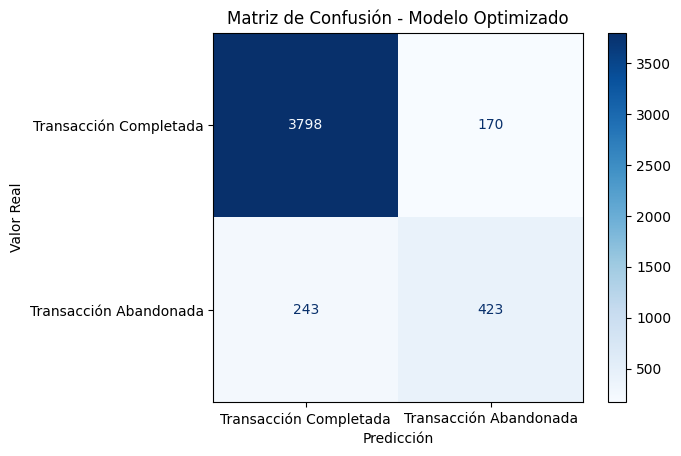

In [60]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Transacción Completada", "Transacción Abandonada"])

disp.plot(cmap=plt.cm.Blues, values_format='d')  # Formato de los valores como enteros
plt.title("Matriz de Confusión - Modelo Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

## [[TN, FP], 
## [FN, TP]] osea 
##
## [[Transacciones completadas clasificadas correctamente, Transacciones completadas clasificadas como abandonadas], 
##  [Transacciones abandonadas clasificadas como completas, Transacciones abandonados clasificadas como abandonadas correctamente]]

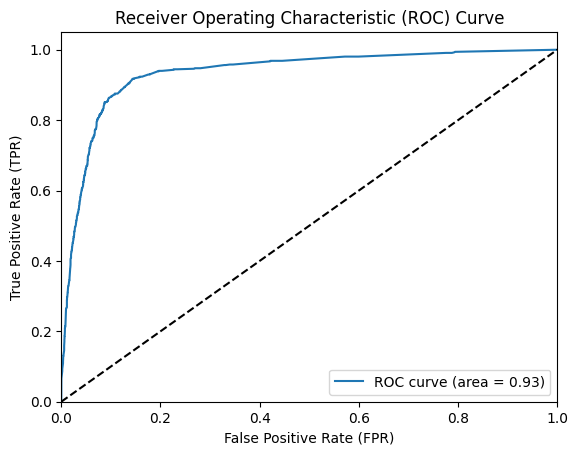

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1]) 

roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

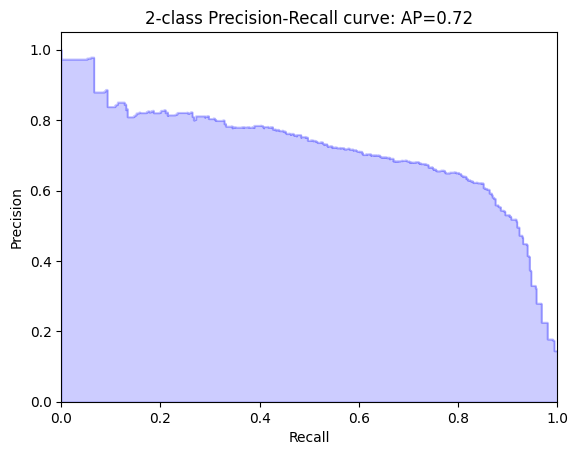

In [65]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_pred_proba[:, 1])

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

plt.show()

In [99]:
columnas = X_train.columns.tolist()

fake_data = {col: [0] for col in columnas} 
fake_data['total_quantity'] = [150]
fake_data['unique_products'] = [1]
fake_data['total_price'] = [21.47]
fake_data['average_price'] = [21.470000]
fake_data['ProductNo_21484'] = [1]  
fake_data['Country_United Kingdom'] = [1]
fake_df = pd.DataFrame(fake_data)


print("fake_df shape:", fake_df.shape)
print("X_train shape:", X_train.shape)

if fake_df.shape[1] == X_train.shape[1]: 
    abandon_prediction = optimized_model.predict(fake_df)
    print("Predicción de abandono (1: Abandonado, 0: Completado):", abandon_prediction[0])
else:
    print("El número de columnas de fake_df no coincide con X_train.")

fake_df shape: (1, 7573)
X_train shape: (18534, 7573)
Predicción de abandono (1: Abandonado, 0: Completado): 0


In [101]:
importances = optimized_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Importancia de las características:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {X_train.columns[indices[f]]} ({importances[indices[f]]})")



Importancia de las características:
1. total_quantity (0.20512278629968306)
2. total_price (0.08292900821104994)
3. Country_United Kingdom (0.07379439499368336)
4. unique_products (0.06181239314845845)
5. average_price (0.027731145485730177)
6. ProductNo_85123A (0.0029679663685120853)
7. ProductName_Cream Hanging Heart T-Light Holder (0.002823317699965983)
8. ProductName_Party Bunting (0.002541958046537376)
9. ProductNo_23084 (0.0024101901684480376)
10. ProductNo_47566 (0.00237052287129645)
11. ProductNo_21034 (0.002341104958186639)
12. ProductName_Jumbo Bag Red Retrospot (0.0022930534259743627)
13. ProductNo_22457 (0.002196623402375541)
14. ProductNo_84879 (0.0021655198566348666)
15. ProductName_Spotty Bunting (0.002034725732989852)
16. ProductNo_22086 (0.0019090521814988345)
17. Country_Germany (0.0018875673802867786)
18. ProductNo_85099B (0.0018458494113641737)
19. ProductName_Rex Cash+Carry Jumbo Shopper (0.0018286997565305704)
20. ProductName_Assorted Colour Bird Ornament (0.00174